# MODELO FASE 4
# Predicción de eventos de fluido eléctrico

### Fuente: NetCool

### Descripción Problema:

* Apartir de los reportes de eventos de Netcool predecir para cada Nodo y Código de Alarma si generá un evento en los próximos día y predecir la severidad que tendrá.
* Solo se consideran equipos BOSS C
* Solo se consideran alarmas seleccionadas para la fase 4 según historia de usuario

### Descripcion Solución implementada

#### Preprocesamiento
1. Se compila la información de los archivos de NetCool (Esto debe cambiar en la industrialización)
2. Se filtran los equipos BOSS C y códigos seleccionados
3. Se resume la información por día y se toman eventos consecutivos como el mismo evento
#### Exploración
4. Se calcula distribución de los eventos a través de los Nodos y códigos.
5. Se caracteriza el intervalo de eventos en cada Nodo y código.
#### Modelado
##### Predicción evento
6. Se definen las series de tiempo para cada Nodo-código
7. Se redefinen la series como la suseción de las distancias en dias entre los eventos presentados para la serie
7. Se clasifican las series para identificar en cuales tiene sentido la predicción
    * Series eventos actuales no tienen predicción
    * Series con solo un evento en la historia no tienen predicción
8. Se aplica la técnica RandomForest para el conjunto de datos de cada código, un modelo para cada código.  *Se validaron varías técnicas y se seleccinó Random Forest*
    * Se implementa validación cruzada y se mide el desempeño de cada modelo (permite validar la mejora en el tiempo al tener más historia)
    * Para los código con menos de 20 series se aplica un suavizado exponencial para predecir los días para el próximos evento, si la predicción es cercana se clasifica
##### Predicción Severidad
9. Se redefine la serie con los valores de severidad registrados
10. Se predice el valor del próximo evento sobre la serie de tiempo
    * Para series con menos de 15 registros se aplica un método simple de forecast, suavisado exponencial
    * Para series con más de 15 registros se aplica el método ETS
    
#### Preparación de la respuesta
11. Se uninen los resultados generados y se genera una salida en archivo csv

### Parámetros generales de la solución

El Script permite modificar adaptar la solución a diferentes requerimientos:
* Número de días próximos a considerar en la predicción
* Número de periodos inter-evento para la estimación
* Reprocesar los archivos fuente o utilizar preprocesamientos anteiores

### Consideraciones

* Se utiliza para el modelamiento solo 10 días de información recopilada de la fuente.   Los archivos base presentaron interrumpción perdiendo continuidad en la historia base en el día 10 (18 de Febrero)
 * Se recomienda realizar una revisión en los parámetros del modelo con mínimo 30 días de información como oportunidad para mejorar las predicciones y validar las métricas de desempeño con más información.

# Configuración ambiente de trabajo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import contextily
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# manejo de archivos
import pandas as pd
import os
import glob

In [2]:
##Modelos
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from croston import croston
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [3]:
from datetime import timedelta
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve #roc_curve
from sklearn.metrics import roc_auc_score #auc

In [4]:
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", -1)

C:\Users\CristhianJohnatanIzq\AppData\Local\Temp\ipykernel_29184\2336295311.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [5]:
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

In [6]:
codeAlarms= pd.read_csv(f'AlarmsCode.csv',sep=';', engine='python',error_bad_lines=False)

# Parámetros Generales de ejecución

In [7]:
#Procesar todos los archivos
actualizacion_archivos=0
#dias próximos a considerar
p_diasEtiqueta=3
#Peridos historicos para el modelo
p_numeroEventos_historia=5

## Preprocesamiento

In [8]:
if actualizacion_archivos==1:
    datosFinal=pd.DataFrame()
    path = os.getcwd()+"\\netcool_new\\"
    print (path)
    csv_files = glob.glob(os.path.join(path, "*.txt"))
    flag=0
    for f in csv_files:
        print('File Name:', f.split("\\")[-1])
        try:            
            df = pd.read_csv(f,sep=';', engine='python',error_bad_lines=False)
            #Filtro BOSSC
            df= df[df['AGENT'].notnull() & df['AGENT'].str.contains("BOSS")]
            # filtro codalarm
            df['CODALARM_2']= pd.to_numeric(df['CODALARM'], errors='coerce')
            df=df[df['CODALARM_2'].isin(codeAlarms['Alarms Codes'].unique())]
            if flag==0:
                datosFinal=df
                flag=1
            else:
                datosFinal=datosFinal.append(df)
        except:
            print("problems opening file")
        #guardar parcial
        datosFinal.to_csv('parcial.csv')
if actualizacion_archivos==0:
    datosFinal=pd.read_csv('parcial.csv')

In [9]:
min_fecha=datosFinal['LASTOCCURRENCE'].min()
print(min_fecha)
max_fecha=datosFinal['LASTOCCURRENCE'].max()
print(max_fecha)

2022-02-07 23:31:32
2022-02-18 02:45:11


In [10]:
datosFinal['NODEALIAS'].nunique()

13197

# Exploración

#### Clasificación de las 25 columnas

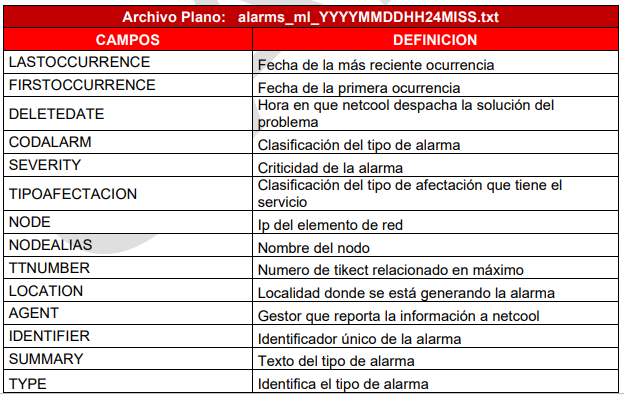
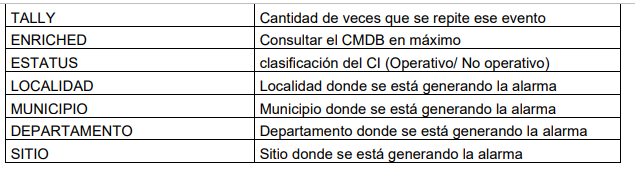

In [11]:
datosFinal.isnull().sum()/len(datosFinal)

Unnamed: 0         0.000000
IDENTIFIER         0.000000
NODE               0.000000
AGENT              0.000000
SEVERITY           0.000000
SUMMARY            0.000000
FIRSTOCCURRENCE    0.000000
LASTOCCURRENCE     0.000000
TYPE               0.000000
TALLY              0.000000
LOCATION           1.000000
DELETEDATE         0.407400
ENRICHED           0.525120
STATUS             0.543604
LOCALIDAD          1.000000
MUNICIPIO          0.546385
DEPARTAMENTO       0.546385
SITIO              0.546385
REGIONAL           0.546385
CODALARM           0.000000
TTNUMBER           0.997573
TECNOLOGIA         0.543604
LATITUD            1.000000
LONGITUD           1.000000
TIPOAFECTACION     0.495006
NODEALIAS          0.000000
CODALARM_2         0.000000
dtype: float64

### Val fechas

In [12]:
datosFinal[datosFinal['FIRSTOCCURRENCE']!=datosFinal['LASTOCCURRENCE']]

,Unnamed: 0,IDENTIFIER,NODE,AGENT,SEVERITY,SUMMARY,FIRSTOCCURRENCE,LASTOCCURRENCE,TYPE,TALLY,LOCATION,DELETEDATE,ENRICHED,STATUS,LOCALIDAD,MUNICIPIO,DEPARTAMENTO,SITIO,REGIONAL,CODALARM,TTNUMBER,TECNOLOGIA,LATITUD,LONGITUD,TIPOAFECTACION,NODEALIAS,CODALARM_2
2,107,5.171.16.213 | 913 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4,5.171.16.213,BOSSC,4.0,Major Analog Alarm For Total String Voltage MAC: 0090EA06DCF6 Voltage: -5:0,2022-02-07 23:24:54,2022-02-07 23:31:34,1.0,11.0,NaN,NaN,Y,OPERATING,NaN,BUCARAMANGA,SANTANDER,COMUNEROS 1 - BUCARAMANGA,ORIENTE,913,NaN,FIJA,NaN,NaN,AS,1CM,913.0
3,108,5.171.16.213 | 975 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4,5.171.16.213,BOSSC,4.0,Major Discrete Alarm For Major Alarm MAC: 0090EA06DCF6 Voltage: -5:0,2022-02-07 23:24:54,2022-02-07 23:31:34,1.0,11.0,NaN,NaN,Y,OPERATING,NaN,BUCARAMANGA,SANTANDER,COMUNEROS 1 - BUCARAMANGA,ORIENTE,975,NaN,FIJA,NaN,NaN,AS,1CM,975.0
7,383,5.218.59.9 | 913 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4,5.218.59.9,BOSSC,0.0,Major Analog Alarm For Total String Voltage MAC: 0090EA026961 Voltage: -5:0,2022-02-07 23:25:30,2022-02-07 23:31:42,1.0,9.0,NaN,2022-02-07 23:36:18,Y,OPERATING,NaN,FUSAGASUGA,CUNDINAMARCA,ALTOS DE PEKIN - FUSAGASUGA,ORIENTE,913,NaN,FIJA,NaN,NaN,AS,ELT,913.0
8,389,5.177.57.201 | 913 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4,5.177.57.201,BOSSC,0.0,Major Analog Alarm For Total String Voltage MAC: 0090EA00447E Voltage: -5:0,2022-02-07 23:23:28,2022-02-07 23:31:42,1.0,9.0,NaN,2022-02-07 23:34:18,Y,OPERATING,NaN,CUCUTA,NORTE DE SANTANDER,LA CARORA PYMES - CUCUTA,ORIENTE,913,NaN,FIJA,NaN,NaN,AS,CRA,913.0
9,390,5.218.59.9 | 975 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4,5.218.59.9,BOSSC,0.0,Major Discrete Alarm For Major Alarm MAC: 0090EA026961 Voltage: -5:0,2022-02-07 23:25:30,2022-02-07 23:31:42,1.0,9.0,NaN,2022-02-07 23:36:18,Y,OPERATING,NaN,FUSAGASUGA,CUNDINAMARCA,ALTOS DE PEKIN - FUSAGASUGA,ORIENTE,975,NaN,FIJA,NaN,NaN,AS,ELT,975.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319281,27150,5.161.96.2 | 9332 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4,5.161.96.2,BOSSC,4.0,Battery on Standby Critical MAC: 0090EA00A67B Voltage: 37.60,2022-02-18 00:14:57,2022-02-18 02:44:58,1.0,287.0,NaN,NaN,Y,OPERATING,NaN,CARTAGENA,BOLIVAR,CAMPESTRE 4 - CARTAGENA,COSTA,9332,NaN,FIJA,NaN,NaN,AS,CPD,9332.0
319282,27151,5.180.5.83 | 9332 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4,5.180.5.83,BOSSC,4.0,Battery on Standby Critical MAC: 0090EA18CF1E Voltage: 35.20,2022-02-18 00:14:58,2022-02-18 02:44:58,1.0,295.0,NaN,NaN,Y,OPERATING,NaN,IBAGUE,TOLIMA,SANTA RITA - IBAGUE,OCCIDENTE,9332,NaN,FIJA,NaN,NaN,AS,SRU,9332.0
319283,27152,5.207.4.142 | 9332 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4,5.207.4.142,BOSSC,4.0,Battery on Standby Critical MAC: 0090EA52B3DC Voltage: 37.20,2022-02-17 22:28:58,2022-02-18 02:44:58,1.0,495.0,NaN,NaN,Y,OPERATING,NaN,GIRARDOT,CUNDINAMARCA,VILLA CATALINA - ESPINAL,ORIENTE,9332,NaN,FIJA,NaN,NaN,AS,ECN,9332.0
319284,27159,5.251.42.39 | 9332 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 3,5.251.42.39,BOSSC,3.0,Battery on Standby MAC: 0090EA00BFCB Voltage: 36.40,2022-02-18 02:43:27,2022-02-18 02:44:59,1.0,3.0,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,9332,NaN,NaN,NaN,NaN,AS,BOG2C8022+,9332.0


### Val identificador

In [13]:
datosFinal['NODE'].nunique()

7750

In [14]:
datosFinal['NODEALIAS'].nunique()

13197

In [15]:
maestroNodos=datosFinal[['NODE','NODEALIAS']].drop_duplicates()

In [16]:
### Identificador más común
datosFinal['IDENTIFIER'].value_counts()

5.19.55.231 | 894 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4            1727
5.48.15.168 | 9332 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4           775 
5.222.32.175 | 894 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4           717 
5.160.10.173 | 9332 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4          691 
5.237.99.1 | 913 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4             665 
                                                                                               ...  
5.131.27.70 | 1012 | Power Supply | 2 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 2 | 18599533    1   
5.218.35.57 | 3304 | Power Supply | 2 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 2 | 18599536    1   
5.218.35.57 | 3304 | Power Supply | 2 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 2 | 18599537    1   
5.218.35.57 | 2 | Power Supply | 2 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 4 | 18599539  

### Analisis y formación Series de Tiempo

In [17]:
datosFinal['fecha']=pd.to_datetime(datosFinal['LASTOCCURRENCE']).dt.date

In [18]:
### quitar primer y última fecha
datosFinal=datosFinal[datosFinal['fecha']!=datosFinal['fecha'].min()]
datosFinal=datosFinal[datosFinal['fecha']!=datosFinal['fecha'].max()]

In [19]:
datosFinal['CODALARM_2']=datosFinal['CODALARM_2'].astype(int)

In [20]:
resumenSeries=datosFinal.groupby(['NODEALIAS','CODALARM_2','fecha'])[['SEVERITY']].max().reset_index()

In [21]:
max_fecha=resumenSeries['fecha'].max()

# Exploración Distribuciones de eventos (Nodos, Codigos, Series)

## Series

In [22]:
resumen_dias_alarma=resumenSeries[['NODEALIAS','CODALARM_2']].value_counts().to_frame()

In [23]:
resumen_dias_alarma.describe()

,0
count,33129.000000
mean,1.895439
std,2.056655
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,10.000000


In [24]:
resumen_dias_alarma_df=resumen_dias_alarma.value_counts().sort_index(ascending=False).to_frame()
resumen_dias_alarma_df.columns=['num_nodos_alarmCodes']

In [25]:
resumen_dias_alarma_df['part']=resumen_dias_alarma_df['num_nodos_alarmCodes']/resumen_dias_alarma_df['num_nodos_alarmCodes'].sum()
resumen_dias_alarma_df.columns=['num_nodos_alarmCodes','part']
resumen_dias_alarma_df.index.name='diasAlarm'
resumen_dias_alarma_df

,num_nodos_alarmCodes,part
0,,
10,1174,0.035437
9,309,0.009327
8,276,0.008331
7,273,0.008241
6,238,0.007184
5,332,0.010021
4,589,0.017779
3,1566,0.047270
2,5640,0.170244


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

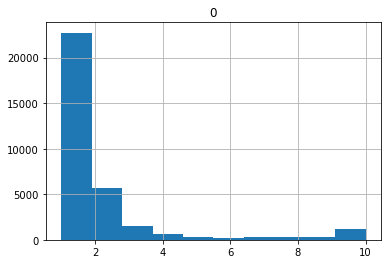

In [26]:
resumen_dias_alarma.hist()

In [27]:
resumen_dias_alarma_df['num_nodos_alarmCodes'].sum()

33129

### Nodo

In [28]:
resumenNodos=datosFinal.groupby(['NODEALIAS','fecha'])[['SEVERITY']].max().reset_index()

In [29]:
resumen_dias_nodo=resumenNodos[['NODEALIAS']].value_counts().to_frame()

In [30]:
resumen_dias_nodo.describe()

,0
count,13155.000000
mean,2.874344
std,2.858017
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,10.000000


In [31]:
resumen_dias_nodo_df=resumen_dias_nodo.value_counts().sort_index(ascending=False).to_frame()

In [32]:
resumen_dias_nodo_df['part']=resumen_dias_nodo_df[0]/resumen_dias_nodo_df[0].sum()
resumen_dias_nodo_df.columns=['num_nodos','part']
resumen_dias_nodo_df

,num_nodos,part
0,,
10,1128,0.085747
9,301,0.022881
8,244,0.018548
7,241,0.018320
6,225,0.017104
5,302,0.022957
4,510,0.038769
3,1135,0.086279
2,2810,0.213607


In [33]:
print("numero Nodos: ",len(resumen_dias_nodo))

numero Nodos:  13155


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

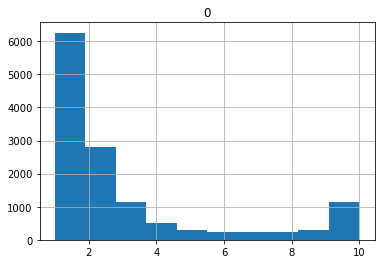

In [34]:
resumen_dias_nodo.hist()

# Preparacion Series

In [35]:
resumenSeries['SEVERITY']=resumenSeries['SEVERITY']+1

In [36]:
resumenSeries['key']=resumenSeries['NODEALIAS']+'---'+resumenSeries['CODALARM_2'].astype(str)

In [37]:
resumenSeries_pv=pd.pivot_table(resumenSeries, index=['fecha'], columns=['key'], values=['SEVERITY'])
resumenSeries_pv.columns = resumenSeries_pv.columns.droplevel()

In [38]:
dias_totales=len(resumenSeries_pv)
dias_totales

10

In [39]:
resumenSeries_pv.fillna(0, inplace=True)

In [40]:
resumenSeries_un=resumenSeries_pv.reset_index().melt(id_vars=['fecha'], var_name='key', value_name='SEVERITY')
resumenSeries_un.set_index('fecha',inplace=True)
resumenSeries_un

,key,SEVERITY
fecha,,
2022-02-08,- CAMPO AZUL---3229,0.0
2022-02-09,- CAMPO AZUL---3229,0.0
2022-02-10,- CAMPO AZUL---3229,0.0
2022-02-11,- CAMPO AZUL---3229,0.0
2022-02-12,- CAMPO AZUL---3229,1.0
...,...,...
2022-02-13,ZVZ---975,0.0
2022-02-14,ZVZ---975,0.0
2022-02-15,ZVZ---975,0.0


#  Recurrencia de Eventos

In [41]:
resumenSeries_un=resumenSeries_un.sort_values(['key','fecha'])

In [42]:
resumenSeries_un_nonZero=resumenSeries_un.reset_index()
resumenSeries_un_nonZero=resumenSeries_un_nonZero[resumenSeries_un_nonZero['SEVERITY']!=0].reset_index()

In [43]:
resumenSeries_un_nonZero['sig_event']=resumenSeries_un_nonZero.groupby('key')['index'].shift(periods=-1)

In [44]:
resumenSeries_un_nonZero['dias_inter_event']=resumenSeries_un_nonZero['sig_event']-resumenSeries_un_nonZero['index']

In [45]:
resumenSeries_un_nonZero['dias_inter_event'].describe()

count    29665.000000
mean     1.777785    
std      1.563032    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      2.000000    
max      9.000000    
Name: dias_inter_event, dtype: float64

<AxesSubplot:>

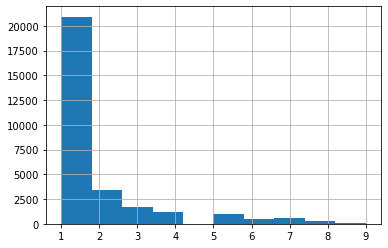

In [46]:
resumenSeries_un_nonZero['dias_inter_event'].hist()

In [47]:
resumenSeries_un_nonZero_df=resumenSeries_un_nonZero['dias_inter_event'].value_counts().to_frame()

In [48]:
resumenSeries_un_nonZero_df['part']=resumenSeries_un_nonZero['dias_inter_event'].value_counts()/len(resumenSeries_un_nonZero)
resumenSeries_un_nonZero_df

,dias_inter_event,part
1.0,20925,0.333232
2.0,3394,0.054050
3.0,1723,0.027439
4.0,1203,0.019158
5.0,942,0.015001
7.0,559,0.008902
6.0,507,0.008074
8.0,329,0.005239
9.0,83,0.001322


In [49]:
resumenSeries_un_nonZero[['NODO','code']] = resumenSeries_un_nonZero['key'].str.split('---',expand=True)

# Clasificacion casos

### Casos Permanentes

In [50]:
# Numero de Eventos por Nodo-Codigo
id_casos=resumenSeries_un_nonZero['key'].value_counts().to_frame().reset_index()
id_casos.columns=['key','num_casos']

In [51]:
id_casos[['NODO','code']] = id_casos['key'].str.split('---',expand=True)

In [52]:
#Alarmas que se presentan permanentemente
id_casos['tipo'] = np.where(id_casos['num_casos']==dias_totales,'permanente',np.nan)

In [53]:
id_casos['tipo'].value_counts()

nan           31955
permanente    1174 
Name: tipo, dtype: int64

In [54]:
id_casos

,key,num_casos,NODO,code,tipo
0,BRS---2934,10,BRS,2934,permanente
1,B55---2934,10,B55,2934,permanente
2,NODO BEX - BELLO 49---2934,10,NODO BEX - BELLO 49,2934,permanente
3,NODO B0E - BELLO 10---2934,10,NODO B0E - BELLO 10,2934,permanente
4,NODO AUC - ARANJUEZ 12---2934,10,NODO AUC - ARANJUEZ 12,2934,permanente
...,...,...,...,...,...
33124,CHIMORPS01---9334,1,CHIMORPS01,9334,nan
33125,CHIMORPS01---893,1,CHIMORPS01,893,nan
33126,CHIMORPS01---833,1,CHIMORPS01,833,nan
33127,CHIMORPS01---827,1,CHIMORPS01,827,nan


In [55]:
id_casos.isnull().sum()

key          0
num_casos    0
NODO         0
code         0
tipo         0
dtype: int64

#### Actualmente Alarma

In [56]:
alarma_actual=resumenSeries_un_nonZero[resumenSeries_un_nonZero['fecha']==max_fecha]

In [57]:
id_casos['tipo'] = np.where(id_casos['tipo']!='nan',id_casos['tipo'],np.where(id_casos['key'].isin(alarma_actual['key'].unique()),'actual',np.NaN))

In [58]:
id_casos['tipo'].value_counts()

nan           27012
actual        4943 
permanente    1174 
Name: tipo, dtype: int64

### Un solo casos (sin repetir cada dia)

In [59]:
casos_mayor_1_df=resumenSeries_un_nonZero[resumenSeries_un_nonZero['dias_inter_event']>1]['key'].unique()

In [60]:
len(set(list(resumenSeries_un_nonZero['key'].unique())))

33129

In [61]:
len(set(list(casos_mayor_1_df)))

7029

In [62]:
#resumenSeries_un
len(set(list(resumenSeries_un['key'].unique())))

33129

In [63]:
casos_solo_1=set(list(resumenSeries_un_nonZero['key'].unique()))-set(list(casos_mayor_1_df))
len(casos_solo_1)

26100

### solo un evento

In [64]:
id_casos['tipo'] = np.where(id_casos['tipo']!='nan',id_casos['tipo'],np.where(id_casos['key'].isin(casos_solo_1),'solo_1','>1_caso'))

## Resumen final

In [65]:
id_casos['tipo'].value_counts()

solo_1        22330
actual        4943 
>1_caso       4682 
permanente    1174 
Name: tipo, dtype: int64

In [66]:
def pieChart(col):
    A = col.value_counts()
    indices = A.index
    plt.pie(A, labels=indices, autopct="%0.1f %%")
    plt.axis("equal")
    plt.show()    

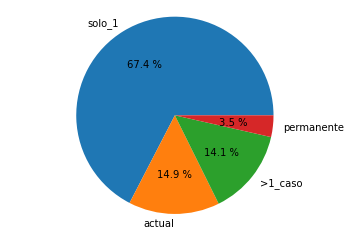

In [67]:
pieChart(id_casos['tipo'])

### Validación
* Espacio para probar casos particulares

In [68]:
id_casos[(id_casos['tipo']=='>1_caso')&(id_casos['num_casos']>3)].sample(3)

,key,num_casos,NODO,code,tipo
2418,CARTRZPS01---894,5,CARTRZPS01,894,>1_caso
2522,GRN2CYPS01---893,5,GRN2CYPS01,893,>1_caso
3140,YB3---913,4,YB3,913,>1_caso


In [69]:
# Espacio para validación de una serie particular
"""resumenSeries_un[resumenSeries_un['key']=='CHICH7PS01---894'][['SEVERITY']].plot.bar(title='CHICH7PS01---894')"""

"resumenSeries_un[resumenSeries_un['key']=='CHICH7PS01---894'][['SEVERITY']].plot.bar(title='CHICH7PS01---894')"

## Descripción de códigos de Alarma
* Mayor frecuencia
* Tiempo en que se demoran en solucionar mean y mediana, contar 1s
* Frecuencia de ocurrencia despúes de solucionar

In [70]:
resumen_dias_code=resumenSeries[['CODALARM_2']].value_counts().to_frame()
resumen_dias_code.columns=['num_casos']
resumen_dias_code

,num_casos
CODALARM_2,
1012,11126
9332,7943
969,6967
2934,5137
891,5089
904,3925
9334,3905
827,3401
913,3118


<AxesSubplot:xlabel='CODALARM_2'>

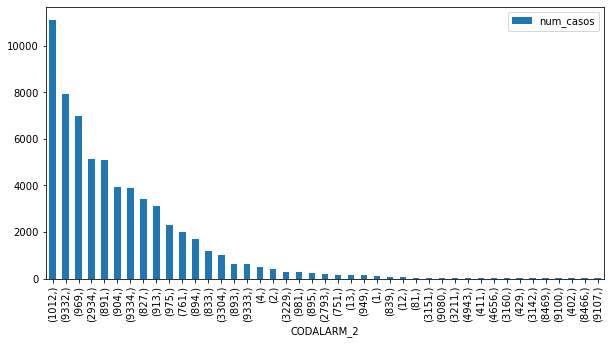

In [71]:
resumen_dias_code.plot.bar(figsize=(10,5))

### Frecuencia Ocurrencia

In [72]:
frecuencia_median_code=resumenSeries_un_nonZero[resumenSeries_un_nonZero['dias_inter_event']>1].groupby('code')[['dias_inter_event']].median()
frecuencia_median_code=frecuencia_median_code.sort_values('dias_inter_event',ascending=False)
frecuencia_median_code

,dias_inter_event
code,
1,5.0
827,4.0
969,4.0
9334,4.0
9332,4.0
3211,3.5
9333,3.0
891,3.0
904,3.0


<AxesSubplot:xlabel='code'>

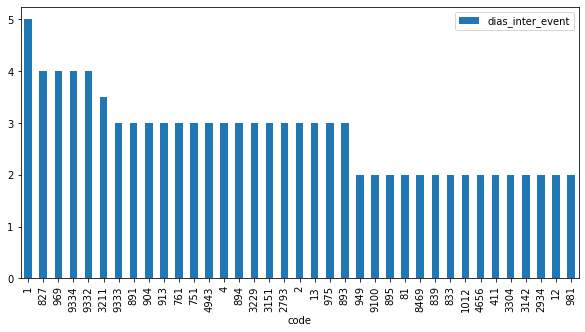

In [73]:
frecuencia_median_code.plot.bar(figsize=(10,5))

<AxesSubplot:title={'center':'dias_inter_event'}, xlabel='[code]'>

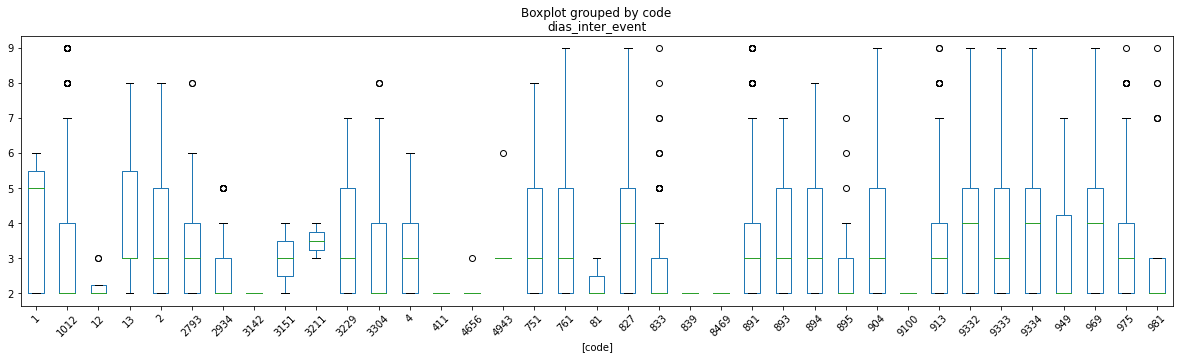

In [74]:
resumenSeries_un_nonZero[resumenSeries_un_nonZero['dias_inter_event']>1][['code','dias_inter_event']].boxplot(by=['code'],figsize=(20,5), grid=False, rot=45)

In [75]:
resumenSeries_un_nonZero[resumenSeries_un_nonZero['code']=='3160']

,index,fecha,key,SEVERITY,sig_event,dias_inter_event,NODO,code
41426,228508,2022-02-16,"NODO 055,552D,553D,554D.---3160",1.0,NaN,NaN,"NODO 055,552D,553D,554D.",3160
41475,228765,2022-02-13,"NODO 34A1,34A12D,34A13D,34A14D.---3160",5.0,NaN,NaN,"NODO 34A1,34A12D,34A13D,34A14D.",3160
41477,228783,2022-02-11,"NODO 3801,38012D,38013D,38014D.---3160",5.0,NaN,NaN,"NODO 3801,38012D,38013D,38014D.",3160
41519,228917,2022-02-15,"NODO 50B,50B2D,50B3D,50B4D.---3160",1.0,NaN,NaN,"NODO 50B,50B2D,50B3D,50B4D.",3160
41640,229272,2022-02-10,"NODO BJ1,BJ12D,BJ13D,BJ14D.---3160",5.0,NaN,NaN,"NODO BJ1,BJ12D,BJ13D,BJ14D.",3160
41792,229916,2022-02-14,"NODO FG2,FG22D,FG23D,FG24D.---3160",1.0,NaN,NaN,"NODO FG2,FG22D,FG23D,FG24D.",3160
41831,230067,2022-02-15,"NODO GH1,GH12D,GH13D,GH14D.---3160",1.0,NaN,NaN,"NODO GH1,GH12D,GH13D,GH14D.",3160
41895,230418,2022-02-16,"NODO LRO2,LRO22D,LRO23D,LRO24D.---3160",5.0,NaN,NaN,"NODO LRO2,LRO22D,LRO23D,LRO24D.",3160
41902,230485,2022-02-13,NODO MAA. - MIRADOR DE ALAMEDA---3160,1.0,NaN,NaN,NODO MAA. - MIRADOR DE ALAMEDA,3160
42093,231200,2022-02-08,"NODO SFT1,SFT12D,SFT13D,SFT14D.---3160",1.0,NaN,NaN,"NODO SFT1,SFT12D,SFT13D,SFT14D.",3160


# Modelado

# Preparación input
* Etiquetas
* Distancias

In [76]:
resumenSeries_un[['NODO','code']] = resumenSeries_un['key'].str.split('---',expand=True)

#### Etiquetas

In [77]:
max_fecha

datetime.date(2022, 2, 17)

In [78]:
fecha_ini_etiqueta=max_fecha - timedelta(days=p_diasEtiqueta-1)
fecha_ini_etiqueta

datetime.date(2022, 2, 15)

In [79]:
df_etiquetas=resumenSeries_un[resumenSeries_un.index>=fecha_ini_etiqueta][['key','SEVERITY']].groupby('key').sum()
df_etiquetas['output']=np.where(df_etiquetas['SEVERITY']>0,1,0)
df_etiquetas

,SEVERITY,output
key,,
- CAMPO AZUL---3229,1.0,1
001AC3FF5272---2934,12.0,1
012---1012,6.0,1
015---1012,0.0,0
01S---761,5.0,1
...,...,...
ZVZ---904,0.0,0
ZVZ---913,0.0,0
ZVZ---9332,0.0,0


### Distancias

In [80]:
df_base=resumenSeries_un[resumenSeries_un.index<fecha_ini_etiqueta]

In [81]:
df_base=df_base.reset_index()
df_distancias_nz=df_base[df_base['SEVERITY']!=0].reset_index()
df_distancias_nz['sig_event']=df_distancias_nz.groupby('key')['index'].shift(periods=-1)
df_distancias_nz['dias_inter_event']=df_distancias_nz['sig_event']-df_distancias_nz['index']

In [82]:
distancias_df=df_distancias_nz[df_distancias_nz['dias_inter_event']>1]

In [83]:
## contar
distancias_df=distancias_df.sort_values(['key','fecha'],ascending=False)

In [84]:
distancias_df.drop(columns=['index','sig_event'],inplace=True)

In [85]:
distancias_df.reset_index(drop=True).reset_index()

,index,fecha,key,SEVERITY,NODO,code,dias_inter_event
0,0,2022-02-08,ZUP---9334,1.0,ZUP,9334,2.0
1,1,2022-02-08,ZUP---827,1.0,ZUP,827,2.0
2,2,2022-02-08,ZTF---9334,4.0,ZTF,9334,2.0
3,3,2022-02-09,ZOV---9334,4.0,ZOV,9334,4.0
4,4,2022-02-09,ZOV---893,1.0,ZOV,893,4.0
...,...,...,...,...,...,...,...
3907,3907,2022-02-10,02J---9332,4.0,02J,9332,3.0
3908,3908,2022-02-08,01S---893,1.0,01S,893,3.0
3909,3909,2022-02-08,01S---827,1.0,01S,827,3.0
3910,3910,2022-02-11,01S---761,1.0,01S,761,2.0


In [86]:
X_df=resumenSeries_un[['key','NODO','code']].drop_duplicates()
X_df.set_index('key',inplace=True)

In [87]:
#Conteo C{odigos
X_df['code'].value_counts()

9332    5765
969     5283
1012    3696
9334    2750
827     2494
904     2382
891     1800
913     1467
894     1236
975     1209
761     1180
2934    579 
893     511 
833     489 
9333    384 
3304    333 
2       222 
4       210 
3229    198 
895     155 
981     140 
2793    123 
751     116 
949     87  
839     75  
12      47  
13      43  
1       42  
3151    20  
411     16  
3160    12  
429     11  
81      11  
4943    9   
3142    8   
3211    7   
402     6   
4656    4   
9080    3   
9100    2   
8469    2   
9107    1   
8466    1   
Name: code, dtype: int64

In [88]:
for i in range(0,p_numeroEventos_historia):
    print(i)
    aux_df=distancias_df.groupby(['key']).nth(i)[['dias_inter_event']]
    aux_df.columns=[i]
    X_df=X_df.merge(aux_df[[i]], left_index=True, right_index=True, how='left')    

0
1
2
3
4


## Dias desde el último evento

In [89]:
df_base=resumenSeries[resumenSeries['fecha']<fecha_ini_etiqueta]

In [90]:
df_ultimo_dia=df_base.groupby('key')[['fecha']].max()

In [91]:
df_ultimo_dia.dtypes

fecha    object
dtype: object

In [92]:
df_ultimo_dia['dias_ultimo_evento']=fecha_ini_etiqueta-df_ultimo_dia['fecha']

In [93]:
df_ultimo_dia['dias_ultimo_eventoV2']=df_ultimo_dia['dias_ultimo_evento'].astype('timedelta64[D]')

In [94]:
df_ultimo_dia['fecha'].max()

datetime.date(2022, 2, 14)

## Construccion Tabla input

In [95]:
### Etiquetas
X_df=X_df.merge(df_etiquetas[['output']], left_index=True, right_index=True, how='left')

In [96]:
X_df.fillna(0,inplace=True)

In [97]:
### Ultimo día
X_df=X_df.merge(df_ultimo_dia[['dias_ultimo_eventoV2']], left_index=True, right_index=True, how='left')

In [98]:
X_df.fillna(1000,inplace=True)

In [99]:
X_df

,NODO,code,0,1,2,3,4,output,dias_ultimo_eventoV2
key,,,,,,,,,
- CAMPO AZUL---3229,- CAMPO AZUL,3229,0.0,0.0,0.0,0.0,0.0,1,3.0
001AC3FF5272---2934,001AC3FF5272,2934,0.0,0.0,0.0,0.0,0.0,1,1000.0
012---1012,012,1012,0.0,0.0,0.0,0.0,0.0,1,1000.0
015---1012,015,1012,0.0,0.0,0.0,0.0,0.0,0,1.0
01S---761,01S,761,2.0,2.0,0.0,0.0,0.0,1,2.0
...,...,...,...,...,...,...,...,...,...
ZVZ---904,ZVZ,904,0.0,0.0,0.0,0.0,0.0,0,4.0
ZVZ---913,ZVZ,913,0.0,0.0,0.0,0.0,0.0,0,4.0
ZVZ---9332,ZVZ,9332,0.0,0.0,0.0,0.0,0.0,0,4.0


In [100]:
# Validacion
X_df.describe()

,0,1,2,3,4,output,dias_ultimo_eventoV2
count,33129.000000,33129.000000,33129.000000,33129.0,33129.0,33129.000000,33129.000000
mean,0.316701,0.025627,0.000483,0.0,0.0,0.449304,244.696067
std,0.988969,0.253164,0.031076,0.0,0.0,0.497431,426.808904
min,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,5.000000
75%,0.000000,0.000000,0.000000,0.0,0.0,1.000000,7.000000
max,6.000000,4.000000,2.000000,0.0,0.0,1.000000,1000.000000


## Ejemplo modelo aplicado una alarma
* Un modelo por codigo de alarma
* Codigos de alarmas con menos de 20 ejemplos (usar otro metodo de ES)

In [101]:
code='1012'
X_df_espe=X_df[X_df['code']==code]
#Si actual = dias ultimo evento 0, no se toma en cuenta
X_df_espe=X_df_espe[X_df_espe['dias_ultimo_eventoV2']>1]
#No se tiene en cuenta series en cero,  estos casos no existiran en la predicción a futuro}
X_df_espe=X_df_espe[X_df_espe[0]>=2]
X_df_espe.set_index('NODO',inplace=True)
X_df_espe=X_df_espe.drop(columns=['code'])
X_df_espe

,0,1,2,3,4,output,dias_ultimo_eventoV2
NODO,,,,,,,
0SD,4.0,0.0,0.0,0.0,0.0,0,2.0
113D,3.0,0.0,0.0,0.0,0.0,1,2.0
11B1,3.0,0.0,0.0,0.0,0.0,0,3.0
15J,2.0,0.0,0.0,0.0,0.0,1,2.0
1AB,2.0,2.0,0.0,0.0,0.0,1,2.0
...,...,...,...,...,...,...,...
YUMGTNPS01,3.0,0.0,0.0,0.0,0.0,1,2.0
YUMLLRPS01,3.0,0.0,0.0,0.0,0.0,1,2.0
YUMYB3PS01,2.0,2.0,0.0,0.0,0.0,0,2.0


In [102]:
pd.crosstab([X_df_espe[0],X_df_espe[1],X_df_espe[2],X_df_espe[3],X_df_espe[4],X_df_espe['dias_ultimo_eventoV2']],X_df_espe['output'])

output                                     0   1
0   1   2   3   4   dias_ultimo_eventoV2        
2.0 0.0 0.0 0.0 0.0 2.0                   18  56
                    3.0                   4   29
                    4.0                   11  8 
                    5.0                   10  9 
    2.0 0.0 0.0 0.0 2.0                   2   6 
                    3.0                   0   9 
    3.0 0.0 0.0 0.0 2.0                   2   5 
3.0 0.0 0.0 0.0 0.0 2.0                   8   21
                    3.0                   6   8 
                    4.0                   16  5 
    2.0 0.0 0.0 0.0 2.0                   1   3 
4.0 0.0 0.0 0.0 0.0 2.0                   11  9 
                    3.0                   6   4 
5.0 0.0 0.0 0.0 0.0 2.0                   1   4

In [103]:
y_df_espe=X_df_espe.pop('output')

In [104]:
y_df_espe.value_counts()

1    176
0    96 
Name: output, dtype: int64

In [105]:
X_df_espe

,0,1,2,3,4,dias_ultimo_eventoV2
NODO,,,,,,
0SD,4.0,0.0,0.0,0.0,0.0,2.0
113D,3.0,0.0,0.0,0.0,0.0,2.0
11B1,3.0,0.0,0.0,0.0,0.0,3.0
15J,2.0,0.0,0.0,0.0,0.0,2.0
1AB,2.0,2.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...
YUMGTNPS01,3.0,0.0,0.0,0.0,0.0,2.0
YUMLLRPS01,3.0,0.0,0.0,0.0,0.0,2.0
YUMYB3PS01,2.0,2.0,0.0,0.0,0.0,2.0


In [106]:
#Train Test
X_train, X_test, y_train, y_test = train_test_split(X_df_espe, y_df_espe, test_size = 0.3, random_state = 86, shuffle= True)

## Random forest

In [107]:
clf=RandomForestClassifier(n_estimators=100, criterion='entropy')

In [108]:
clf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy')

In [109]:
pred_test=clf.predict(X_test)
pred_test

array([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0])

In [110]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

dias_ultimo_eventoV2    0.452124
0                       0.426007
1                       0.121869
2                       0.000000
3                       0.000000
4                       0.000000
dtype: float64

In [111]:
roc_auc_score(y_test, pred_test)

0.6947368421052632

In [112]:
confusion_matrix(y_test, pred_test)

array([[15, 10],
       [12, 45]], dtype=int64)

### Loop sobre todos los tipos de Alarmas (más de 20 casos)

In [113]:
modelosClass={}
for cod in resumen_dias_code.reset_index()['CODALARM_2']:
    print(cod)
    dicModelo={}
    #preparacion
    code=cod
    X_df_espe=X_df[X_df['code']==str(code)]
    n_reg_ini=len(X_df_espe)    
    #Si actual = dias ultimo evento 0, no se toma en cuenta
    X_df_espe=X_df_espe[X_df_espe['dias_ultimo_eventoV2']>1]
    #No se tiene en cuenta series en cero,  estos casos no existiran en la predicción a futuro}
    X_df_espe=X_df_espe[X_df_espe[0]>=2]

    X_df_espe.set_index('NODO',inplace=True)
    X_df_espe=X_df_espe.drop(columns=['code'])
    y_df_espe=X_df_espe.pop('output')
    ## Validar si tiene más de 20 casos
    print("numReg",len(X_df_espe))
    if len(X_df_espe)>=20:
        #Train Test
        X_train, X_test, y_train, y_test = train_test_split(X_df_espe, y_df_espe, test_size = 0.3, random_state = 86, shuffle= True)        
        #Modelado
        dicModelo['modelo']=RandomForestClassifier(n_estimators=100, criterion='entropy')   
        dicModelo['modelo']=dicModelo['modelo'].fit(X_train,y_train)
        pred_test=dicModelo['modelo'].predict(X_test)
        #metricas
        dicModelo['accuracy']=metrics.accuracy_score(y_test, pred_test)
        if len(np.unique(pred_test))<2:
            dicModelo['auc']=0
        else:
            dicModelo['auc']=roc_auc_score(y_test, pred_test)   
        dicModelo['validacion']=1
    else:
        dicModelo['validacion']=0
    dicModelo['n_reg']=len(X_df_espe)
    dicModelo['n_reg_ini']=n_reg_ini
    # guardar en diccionario general
    modelosClass[cod]=dicModelo

1012
numReg 272
9332
numReg 347
969
numReg 289
2934
numReg 36
891
numReg 139
904
numReg 134
9334
numReg 174
827
numReg 151
913
numReg 60
975
numReg 39
761
numReg 53
894
numReg 53
833
numReg 25
3304
numReg 12
893
numReg 16
9333
numReg 30
4
numReg 30
2
numReg 17
3229
numReg 10
981
numReg 2
895
numReg 7
2793
numReg 7
751
numReg 0
13
numReg 3
949
numReg 2
1
numReg 1
839
numReg 2
12
numReg 4
81
numReg 1
3151
numReg 0
9080
numReg 0
3211
numReg 1
4943
numReg 0
411
numReg 1
4656
numReg 3
3160
numReg 0
429
numReg 0
3142
numReg 0
8469
numReg 0
9100
numReg 0
402
numReg 0
8466
numReg 0
9107
numReg 0


# Resultados Actuales modelos de clasificación

In [114]:
pd.DataFrame.from_dict(modelosClass)[1:].T

,accuracy,auc,validacion,n_reg,n_reg_ini
1012,0.731707,0.694737,1,272,3696
9332,0.666667,0.567029,1,347,5765
969,0.747126,0.572761,1,289,5283
2934,1.0,0,1,36,579
891,0.547619,0.5,1,139,1800
904,0.682927,0.604885,1,134,2382
9334,0.660377,0.642105,1,174,2750
827,0.782609,0.644444,1,151,2494
913,0.555556,0.584416,1,60,1467
975,0.583333,0.5,1,39,1209


# Pronostico futuro

#####  Construcción Base

In [115]:
df_base=resumenSeries_un.copy()
df_base=df_base.reset_index()

In [116]:
df_distancias_nz=df_base[df_base['SEVERITY']!=0].reset_index()
df_distancias_nz['sig_event']=df_distancias_nz.groupby('key')['index'].shift(periods=-1)
df_distancias_nz['dias_inter_event']=df_distancias_nz['sig_event']-df_distancias_nz['index']

In [117]:
distancias_df=df_distancias_nz[df_distancias_nz['dias_inter_event']>1]

In [118]:
distancias_df=distancias_df.sort_values(['key','fecha'],ascending=False)

In [119]:
distancias_df.drop(columns=['index','sig_event'],inplace=True)

In [120]:
#base
X_df=resumenSeries_un[['key','NODO','code']].drop_duplicates()
X_df.set_index('key',inplace=True)

In [121]:
#intervalos
for i in range(0,p_numeroEventos_historia):
    print(i)
    aux_df=distancias_df.groupby(['key']).nth(i)[['dias_inter_event']]
    aux_df.columns=[i]
    X_df=X_df.merge(aux_df[[i]], left_index=True, right_index=True, how='left')

0
1
2
3
4


In [122]:
#ultimo dia
df_base=resumenSeries.copy()
df_ultimo_dia=df_base.groupby('key')[['fecha']].max()
df_ultimo_dia['dias_ultimo_evento']=max_fecha-df_ultimo_dia['fecha']  #cambiar a max_fecha
df_ultimo_dia['dias_ultimo_eventoV2']=df_ultimo_dia['dias_ultimo_evento'].astype('timedelta64[D]')

In [123]:
#construccion tabla
#union intervalos
X_df.fillna(0,inplace=True)
### Ultimo día
X_df=X_df.merge(df_ultimo_dia[['dias_ultimo_eventoV2']], left_index=True, right_index=True, how='left')
X_df.fillna(1000,inplace=True)

In [124]:
X_df.loc['SJ1---1012']

NODO                    SJ1 
code                    1012
0                       0.0 
1                       0.0 
2                       0.0 
3                       0.0 
4                       0.0 
dias_ultimo_eventoV2    6.0 
Name: SJ1---1012, dtype: object

#### Calculo predicción

In [125]:
X_df['dias_ultimo_eventoV2'].value_counts()

0.0    6117
1.0    4634
2.0    4134
4.0    3516
3.0    3038
9.0    2966
6.0    2567
7.0    2387
8.0    2008
5.0    1762
Name: dias_ultimo_eventoV2, dtype: int64

In [126]:
finalPrediccionesFuturas = pd.DataFrame()

In [127]:
### Predicción regresión
def pred_reg(X):
    model = SimpleExpSmoothing(X)
    model=model.fit(smoothing_level=.5)
    return model.forecast(1)

In [128]:
i=0
for cod in resumen_dias_code.reset_index()['CODALARM_2']:
    X_df_espe=X_df[X_df['code']==str(cod)] 
    ##clasificación Casos
    print(cod, "tam:",len(X_df_espe))
    X_df_espe['estado']=np.where(X_df_espe['dias_ultimo_eventoV2']>=1,'valido','actual')    
    #No se tiene en cuenta series en cero,  estos casos no existiran en la predicción a futuro    
    X_df_espe['estado']=np.where(X_df_espe['estado']=='actual','actual',np.where(X_df_espe[0]>=2,'valido','solo un evento'))    
    X_df_espe['class_model']=modelosClass[cod]['validacion']
    
    #filtro    
    X_df_espe_actual=X_df_espe[X_df_espe['estado']!='valido']    
    X_df_espe_class=X_df_espe[(X_df_espe['estado']=='valido')&(X_df_espe['class_model']==1)]    
    X_df_espe_reg=X_df_espe[(X_df_espe['estado']=='valido')& (X_df_espe['class_model']!=1)]    
    
    if len(X_df_espe_class)>0:
        X_df_espe_class['prediccion']=modelosClass[cod]['modelo'].predict(X_df_espe_class.drop(columns=['NODO','code','class_model','estado']))
        X_df_espe_class['probabilidad']=1-modelosClass[cod]['modelo'].predict_proba(X_df_espe_class.drop(columns=['NODO','code','class_model','estado','prediccion']))[:,0]     
    
    if len(X_df_espe_actual)>0:
        X_df_espe_actual['prediccion']=np.where(X_df_espe_actual['estado']=='actual',1,0)
        X_df_espe_actual['probabilidad']=np.where(X_df_espe_actual['estado']=='actual',1,0)        
        X_df_espe_actual['prediccion']=np.where(X_df_espe_actual['estado']=='solo un evento',0,X_df_espe_actual['prediccion'])
        X_df_espe_actual['probabilidad']=np.where(X_df_espe_actual['estado']=='solo un evento',0,X_df_espe_actual['probabilidad'])
        
    if len(X_df_espe_reg)>0:
        X_df_espe_reg['prediccion']=int(X_df_espe_reg.drop(columns=['NODO','code','class_model','estado','dias_ultimo_eventoV2']).apply(lambda row: pred_reg(row.values), axis=1)[0])
        X_df_espe_reg['prediccion']=np.where(X_df_espe_reg['prediccion']<=X_df_espe_reg['dias_ultimo_eventoV2'],0,X_df_espe_reg['prediccion'])
        X_df_espe_reg['probabilidad']=0.2    
    
    if i==0:
        finalPrediccionesFuturas=X_df_espe_class.copy()
        i=i+1
    else :        
        finalPrediccionesFuturas=finalPrediccionesFuturas.append(X_df_espe_class.copy())
        
    finalPrediccionesFuturas=finalPrediccionesFuturas.append(X_df_espe_reg.copy())  
    finalPrediccionesFuturas=finalPrediccionesFuturas.append(X_df_espe_actual.copy())

1012 tam: 3696
9332 tam: 5765
969 tam: 5283
2934 tam: 579
891 tam: 1800
904 tam: 2382
9334 tam: 2750
827 tam: 2494
913 tam: 1467
975 tam: 1209
761 tam: 1180
894 tam: 1236
833 tam: 489
3304 tam: 333
893 tam: 511
9333 tam: 384
4 tam: 210
2 tam: 222
3229 tam: 198
981 tam: 140
895 tam: 155
2793 tam: 123
751 tam: 116
13 tam: 43
949 tam: 87
1 tam: 42
839 tam: 75
12 tam: 47
81 tam: 11
3151 tam: 20
9080 tam: 3
3211 tam: 7
4943 tam: 9
411 tam: 16
4656 tam: 4
3160 tam: 12
429 tam: 11
3142 tam: 8
8469 tam: 2
9100 tam: 2
402 tam: 6
8466 tam: 1
9107 tam: 1


In [129]:
#val duplicados
finalPrediccionesFuturas.reset_index()['key'].value_counts()

069---1012                    1
TT1---9334                    1
UBL---9334                    1
UBAUJ2PS01---9334             1
UBAETEPS01---9334             1
                             ..
BOG1OSPS01---969              1
BOG1OEPS01---969              1
BOG1LIPS01---969              1
BOG1ITPS01---969              1
17 MaxNetII MPRF-BH---9107    1
Name: key, Length: 33129, dtype: int64

In [130]:
finalPrediccionesFuturas['prediccion'].value_counts()

0.0    25744
1.0    7385 
Name: prediccion, dtype: int64

In [131]:
finalPrediccionesFuturas['estado'].value_counts()

solo un evento    22330
actual            6117 
valido            4682 
Name: estado, dtype: int64

In [132]:
pd.crosstab(finalPrediccionesFuturas['prediccion'],finalPrediccionesFuturas['estado'])

estado,actual,solo un evento,valido
prediccion,,,
0.0,0,22330,3414
1.0,6117,0,1268


In [133]:
print("# series sin pronostico: ", len(finalPrediccionesFuturas[finalPrediccionesFuturas['prediccion'].isnull()]))

# series sin pronostico:  0


In [134]:
print("Series no consideradas: ",set(list(resumenSeries['key'].unique()))-set(list(finalPrediccionesFuturas.index)))

Series no consideradas:  set()


In [135]:
finalPrediccionesFuturas

,NODO,code,0,1,2,3,4,dias_ultimo_eventoV2,estado,class_model,prediccion,probabilidad
key,,,,,,,,,,,,
069---1012,069,1012,2.0,0.0,0.0,0.0,0.0,1.0,valido,1,1.0,0.750052
080---1012,080,1012,5.0,0.0,0.0,0.0,0.0,1.0,valido,1,1.0,0.652841
0SD---1012,0SD,1012,4.0,0.0,0.0,0.0,0.0,4.0,valido,1,0.0,0.239270
11B1---1012,11B1,1012,3.0,0.0,0.0,0.0,0.0,5.0,valido,1,0.0,0.319218
14A12D---1012,14A12D,1012,5.0,0.0,0.0,0.0,0.0,2.0,valido,1,1.0,0.652841
...,...,...,...,...,...,...,...,...,...,...,...,...
NODO TB1. - TIBABITA I---402,NODO TB1. - TIBABITA I,402,0.0,0.0,0.0,0.0,0.0,9.0,solo un evento,0,0.0,0.000000
"NODO VJ1,VJ12D,VJ13D,VJ14D.---402","NODO VJ1,VJ12D,VJ13D,VJ14D.",402,0.0,0.0,0.0,0.0,0.0,7.0,solo un evento,0,0.0,0.000000
SG4000 19D25D---402,SG4000 19D25D,402,0.0,0.0,0.0,0.0,0.0,9.0,solo un evento,0,0.0,0.000000


## Prediccion de severidad
* Predecir severidad (ets para más de 15registros)
* Solo predecir con evento próximos días

In [136]:
groupedPred =resumenSeries_un_nonZero[resumenSeries_un_nonZero['key'].isin(finalPrediccionesFuturas[finalPrediccionesFuturas['prediccion']==1].index)][['key','NODO','code','SEVERITY']].groupby('key')

In [137]:
predSeverity=pd.DataFrame(columns=['key','Nodo','Codigo','pred','metodo'])
for g in groupedPred.groups:     
    #print(g)
    group = groupedPred.get_group(g)
    num_reg=len(group)
    if num_reg==1:
        forecast=group['SEVERITY'].values[0]
        met='anterior'       
    elif num_reg>15 :
        periodos = 10 if int(num_reg/2)>10 else int(num_reg/2)
        model = ETSModel(group['SEVERITY'].astype(float),seasonal_periods=periodos ,error="add",trend="add",seasonal="add", damped_trend=True,)
        model = model.fit()
        forecast = model.get_prediction(start=num_reg, end=num_reg).summary_frame(alpha=0.05)['mean'].values[0]
        met='ets'
    else:        
        model = SimpleExpSmoothing(group['SEVERITY'].values)
        model= model.fit(smoothing_level=.5)
        forecast=model.forecast(1)[0]
        met='es'       
    #row    
    (a_nodo,a_codigo)=g.split("---")
    new_row=pd.DataFrame([pd.Series([g,a_nodo,a_codigo,forecast,met])])
    new_row.columns=['key','Nodo','Codigo','pred','metodo']   
    
    predSeverity = predSeverity.append(new_row)
    

## Preparación Respuesta

In [138]:
resultadoFinal=finalPrediccionesFuturas.merge(predSeverity,left_index=True, right_on=['key'], how='left')

In [139]:
len(resultadoFinal)

33129

In [140]:
resultadoFinal=resultadoFinal[['NODO','code','estado','class_model','prediccion','probabilidad','pred','metodo']].reset_index(drop=True)

In [141]:
resultadoFinal.columns=['NODO','CODIGO_ALARMA','TIPO','MODELO_CLASIFICACION','PRED_EVENTO','PROBABILIDAD','PRED_SEVERIDAD','METODO_SEV']

In [142]:
resultadoFinal['PRED_SEVERIDAD']=resultadoFinal['PRED_SEVERIDAD']-1

In [143]:
resultadoFinal

,NODO,CODIGO_ALARMA,TIPO,MODELO_CLASIFICACION,PRED_EVENTO,PROBABILIDAD,PRED_SEVERIDAD,METODO_SEV
0,069,1012,valido,1,1.0,0.750052,3.0,es
1,080,1012,valido,1,1.0,0.652841,2.0,es
2,0SD,1012,valido,1,0.0,0.239270,NaN,NaN
3,11B1,1012,valido,1,0.0,0.319218,NaN,NaN
4,14A12D,1012,valido,1,1.0,0.652841,3.0,es
...,...,...,...,...,...,...,...,...
33124,NODO TB1. - TIBABITA I,402,solo un evento,0,0.0,0.000000,NaN,NaN
33125,"NODO VJ1,VJ12D,VJ13D,VJ14D.",402,solo un evento,0,0.0,0.000000,NaN,NaN
33126,SG4000 19D25D,402,solo un evento,0,0.0,0.000000,NaN,NaN
33127,17 MaxNetII MPRF-BH,8466,solo un evento,0,0.0,0.000000,NaN,NaN


In [144]:
resultadoFinal.to_csv('prediccionFase4.csv')

## Preguntas finales
* Formato de la historia
* Validar Formato Entregable